In [ ]:
# Importing Googe Drive
from google.colab import drive
import sys, os
drive.mount('/content/drive/')

sys.path.append('/content/drive/Shareddrives/CFA project/utils')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Importing necessary packages and libraries
# Niu: added the first line to update openpyxl, which is necessary for pandas to read databases

!pip install openpyxl --upgrade

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
import statsmodels.api as sm
from functools import reduce

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data pre-processing

In [ ]:
!pip install category_encoders

     |████████████████████████████████| 86 kB 3.0 MB/s 


In [ ]:
from category_encoders.target_encoder import TargetEncoder
from category_encoders.sum_coding import SumEncoder
from category_encoders.m_estimate import MEstimateEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder
from category_encoders.binary import BinaryEncoder
from category_encoders.cat_boost import CatBoostEncoder
from category_encoders.james_stein import JamesSteinEncoder
from category_encoders.one_hot import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_pickle('/content/drive/Shareddrives/CFA project/data/loaded_df.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20020 entries, 14824 to 20019
Data columns (total 30 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Stock                            20020 non-null  object 
 1   Free.Operating.Cash.Flow         20019 non-null  float64
 2   Total.Debt.Outstanding           20020 non-null  float64
 3   Price.Close                      20020 non-null  float64
 4   Total.Common.Shares.Outstanding  20020 non-null  int64  
 5   Cash.and.Equivalents             20020 non-null  int64  
 6   Net.Income                       20020 non-null  int64  
 7   Interest.Expense                 19415 non-null  float64
 8   Short.Interest                   20020 non-null  float64
 9   Avg.Daily.Volume.30D             20020 non-null  int64  
 10  Current.Assets                   20020 non-null  float64
 11  Non.Current.Assets               20020 non-null  float64
 12  Current.Liabil

In [ ]:
df = df.dropna(subset=['age','sector','industry']).reset_index(drop=True)

In [ ]:
df = df.sort_values(by=['DATE'])
df[['Free.Operating.Cash.Flow', 'Interest.Expense']] = df.groupby('Stock')[['Free.Operating.Cash.Flow', 'Interest.Expense']].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))

In [ ]:
df.isna().sum()

Stock                              0
Free.Operating.Cash.Flow           0
Total.Debt.Outstanding             0
Price.Close                        0
Total.Common.Shares.Outstanding    0
Cash.and.Equivalents               0
Net.Income                         0
Interest.Expense                   0
Short.Interest                     0
Avg.Daily.Volume.30D               0
Current.Assets                     0
Non.Current.Assets                 0
Current.Liabilities                0
RSI.Exponential                    0
MACD.Line1                         0
Bollinger.Band,Width               0
Price.Mo.Volatility.T12M           0
3M.Sharpe.Ratio                    0
DATE                               0
CPIAUCSL                           0
PAYEMS                             0
PPIACO                             0
T10YIE                             0
T5YIE                              0
UNRATE                             0
industry                           0
age                                0
M

In [ ]:
fundamentals = ['Free.Operating.Cash.Flow', 'Total.Debt.Outstanding',
       'Total.Common.Shares.Outstanding',
       'Cash.and.Equivalents', 'Net.Income', 'Interest.Expense',
       'Short.Interest', 'Avg.Daily.Volume.30D', 'Current.Assets',
       'Non.Current.Assets', 'Current.Liabilities']

technicals = ['RSI.Exponential','MACD.Line1', 'Bollinger.Band,Width', 'Price.Mo.Volatility.T12M']

macros_features = ['CPIAUCSL', 'PAYEMS', 'PPIACO', 'T10YIE', 'T5YIE','UNRATE']

In [ ]:
# keep two types of data: X: [attributes] -> y: close price
#                         X: [pct_change_attributes] -> y: pct_change in close price
#TODO: determine y: average? EWA? One single close may not show the whole level of increase/decrease
df = df.sort_values(by=['DATE'])
df_val = df.copy()
df_val['next_close'] = df_val.groupby(['Stock'])['Price.Close'].transform(lambda x: x.shift(-1))
df_diff = df.copy()

# calculate pct_diff as y
df_diff['pct_change_close'] = df_diff.groupby(['Stock'])['Price.Close'].transform(lambda x: x.pct_change().shift(-1))

## fundamental, close price, and macro shall be saved as pct_change to reflect the pct_change in y; 
##TODO: shall technical indicators be counted as pct_change as well or remain as is?
# features_as_pct = fundamentals + ['Price.Close'] + macros_features
# df_diff[features_as_pct] = df_diff.groupby(['Stock'])[features_as_pct].transform(lambda x: x.pct_change())[features_as_pct]

In [ ]:
df_val = df_val.dropna(subset=['next_close']).reset_index(drop=True)

In [ ]:
df_diff = df_diff.dropna(subset=['pct_change_close']).reset_index(drop=True)

Stock


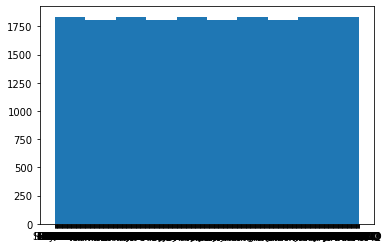

Free.Operating.Cash.Flow


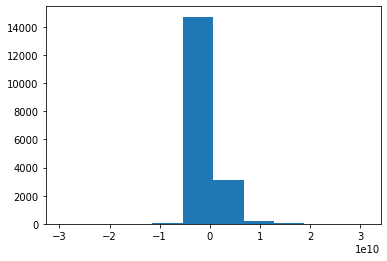

Total.Debt.Outstanding


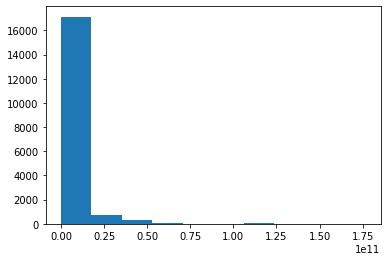

Price.Close


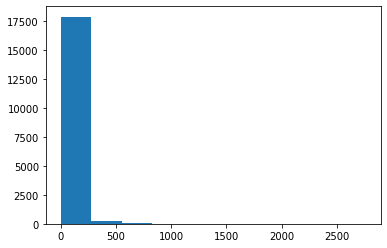

Total.Common.Shares.Outstanding


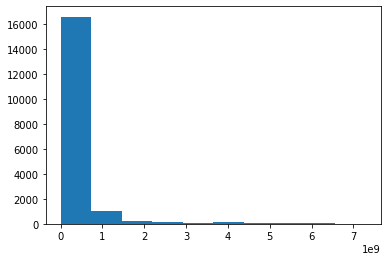

Cash.and.Equivalents


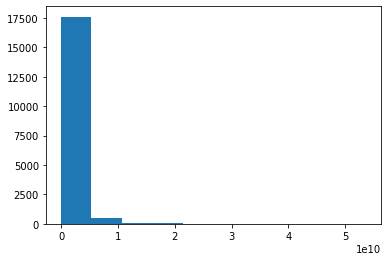

Net.Income


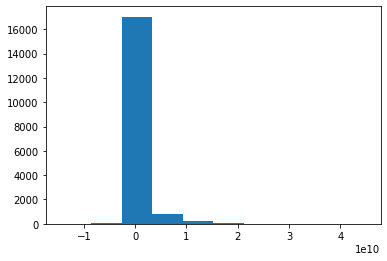

Interest.Expense


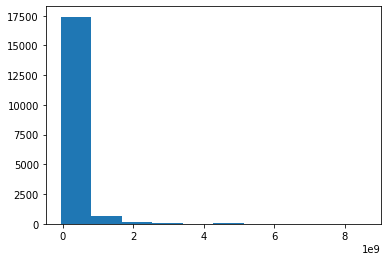

Short.Interest


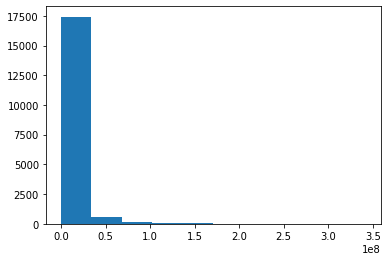

Avg.Daily.Volume.30D


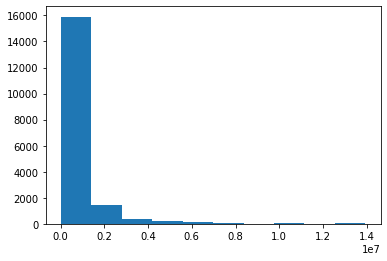

Current.Assets


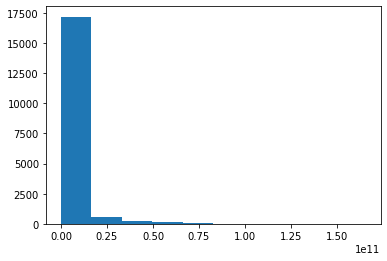

Non.Current.Assets


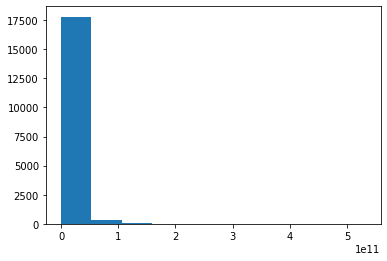

Current.Liabilities


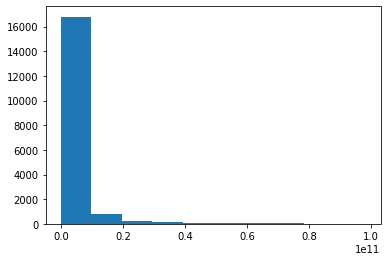

RSI.Exponential


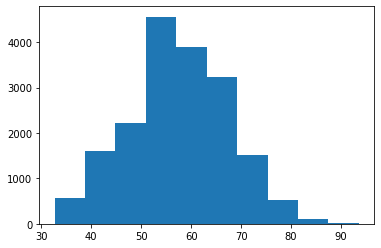

MACD.Line1


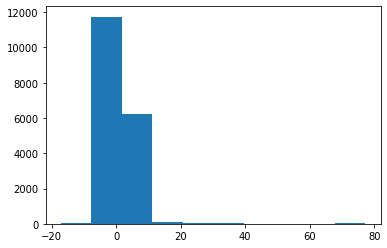

Bollinger.Band,Width


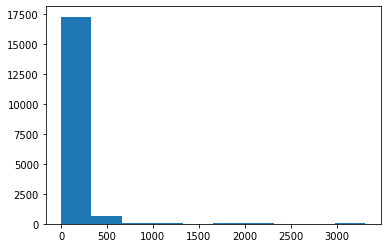

Price.Mo.Volatility.T12M


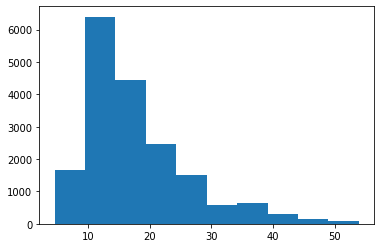

3M.Sharpe.Ratio


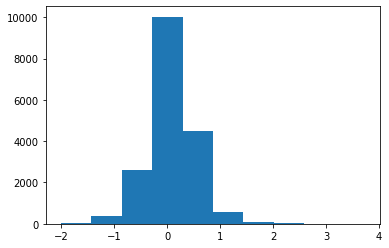

DATE


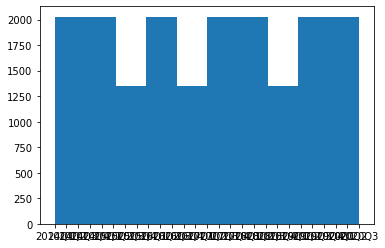

CPIAUCSL


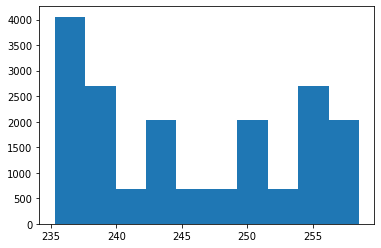

PAYEMS


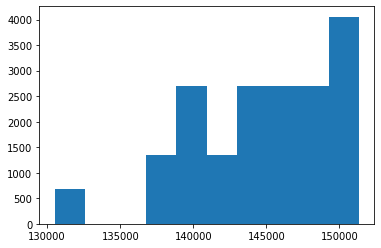

PPIACO


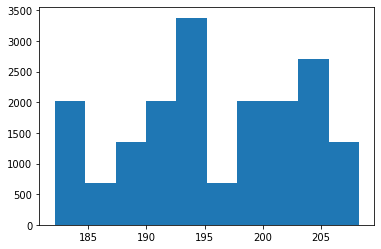

T10YIE


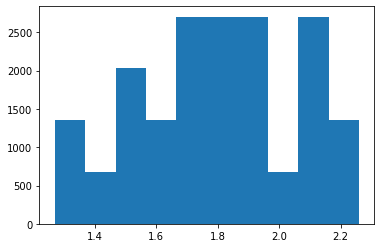

T5YIE


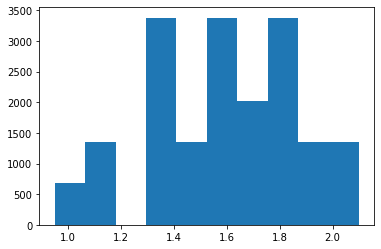

UNRATE


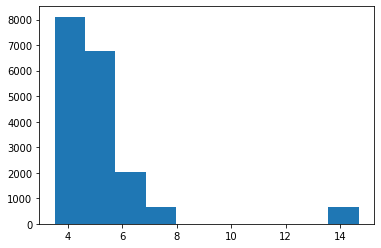

industry


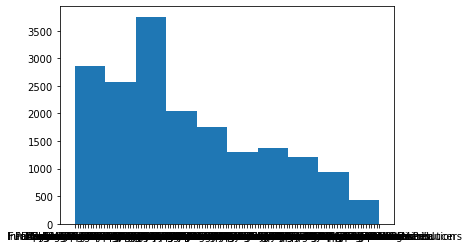

age


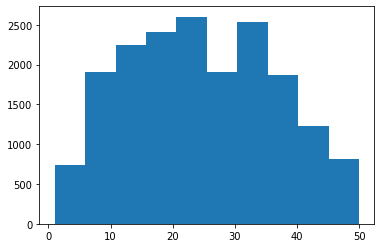

Month_sin


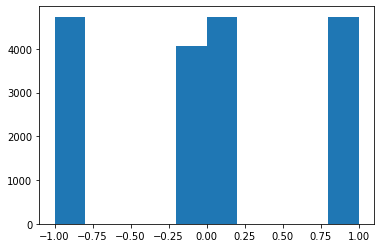

Month_cos


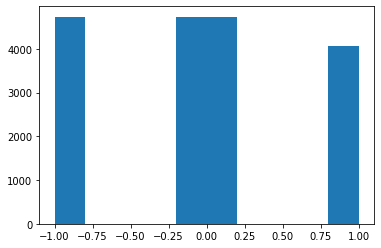

sector


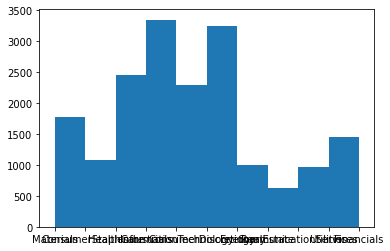

next_close


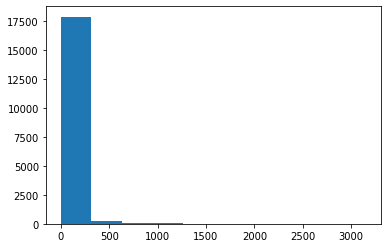

In [ ]:
import matplotlib.pyplot as plt

for col in df_val.columns:
  print(col)
  plt.hist(df_val[col])  
  plt.show()

Check if there is missing any quarter -- since time series shall be continuous

In [ ]:
df_val.sort_values(by=['DATE'])['DATE'].unique()

array(['2014Q1', '2014Q2', '2014Q3', '2014Q4', '2015Q1', '2015Q2',
       '2015Q3', '2015Q4', '2016Q1', '2016Q2', '2016Q3', '2016Q4',
       '2017Q1', '2017Q2', '2017Q3', '2017Q4', '2018Q1', '2018Q2',
       '2018Q3', '2018Q4', '2019Q1', '2019Q2', '2019Q3', '2019Q4',
       '2020Q1', '2020Q2', '2020Q3'], dtype=object)

In [ ]:
df_val['DATE'].value_counts()

2014Q1    676
2017Q3    676
2020Q2    676
2020Q1    676
2019Q4    676
2019Q3    676
2019Q2    676
2019Q1    676
2018Q4    676
2018Q3    676
2018Q2    676
2018Q1    676
2017Q4    676
2017Q2    676
2014Q2    676
2017Q1    676
2016Q4    676
2016Q3    676
2016Q2    676
2016Q1    676
2015Q4    676
2015Q3    676
2015Q2    676
2015Q1    676
2014Q4    676
2014Q3    676
2020Q3    676
Name: DATE, dtype: int64

In [ ]:
import seaborn as sns
sns.set(rc={'figure.figsize': (11,8)})
sns.heatmap(X_train.corr())

NameError: ignored

In [ ]:
col_2_drop = ['T5YIE', 'Price.Close', '3M.Sharpe.Ratio', 'PAYEMS']
df_val = df_val.drop(columns=col_2_drop)

In [ ]:
col_2_drop = ['T5YIE', 'Price.Close', '3M.Sharpe.Ratio', 'PAYEMS']
df_diff = df_diff.drop(columns=col_2_drop)

# LSTM

### Prepare data in sequential 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
df_diff.info()

In [ ]:
def prepare_data(data, L, clip_outliers_cols,  drop_features, y_feature, test_size, normalize_cols, clip_quantile = 0.99, encoding_method='BinaryEncoder',
                 train_test_split_type='random', normalize_method='RobustScaler',
                 encoding_col='sector', sigma=0, random_seed=40):
    """

  :param data:
  :param L: sequence length
  :param drop_features: features to drop
  :param y_feature:
  :param train_test_split_type: 'random': randomly split ; 'time': split by a quarter e.g., 2019Q4. Default random
  :param test_size: if train_test_slit == 'random': test/all, e.g. 0.3. else: the quarter string to split
  :param encoding_method: str() of encoder to use. Default binaryencoder
  :param encoding_col: col name to encode
  :param sigma: for LOO and catboost encoder -- gaussian noise added to the encoder
  :param random_seed: random_seed for train_test_split under the random mode.
  :return: tuple of X_train, X_test, y_train, y_test
  """

    df = data.copy()
    df = df.sort_values(by=['DATE']).reset_index(drop=True)
    # for col in clip_outliers_cols:
    #   percentiles = df[col].quantile([1-clip_quantile, clip_quantile]).values
    #   df[col] = np.clip(data[col], percentiles[0], percentiles[1])
    X, y = df.drop(columns=[y_feature]), df[y_feature]
    # if split dataset randomly
    if train_test_split_type == 'random':
        X_idx_list = []
        y_idx_list = []
        # TargetEncoder, LOO and CatBoost requires the knowledge of target feature
        # To prevent information leakage, we first store idx for each sequence; then
        # randomly split into train-test, calculate the encodings, and convert back
        for ticker, group in df.groupby('Stock'):
            for i in range(len(group) - L + 1):
                X_idx_list.append(group.iloc[i:i + L].index.to_numpy())
                y_idx_list.append(group.iloc[i + L - 1].name)

        X_train, X_test, y_train, y_test = train_test_split(X_idx_list, y_idx_list, test_size=test_size,
                                                            random_state=random_seed)
        test_idx = df.loc[y_test][['Stock', 'DATE']]
    # if split dataset by a time (quarter)
    else:
        train, test = df[df['DATE'] < test_size].sort_values(by=['DATE']), df[df['DATE'] >= test_size].sort_values(
            by=['DATE'])
        X_train, X_test, y_train, y_test = [], [], [], []
        for ticker, group in train.groupby("Stock"):
            for i in range(len(group) - L + 1):
                X_train.append(group.iloc[i:i + L].index.to_numpy())
                y_train.append(group.iloc[i + L - 1].name)
        for ticker, group in test.groupby("Stock"):
            for i in range(len(group) - L + 1):
                X_test.append(group.iloc[i:i + L].index.to_numpy())
                y_test.append(group.iloc[i + L - 1].name)
        test_idx = df.loc[y_test][['Stock', 'DATE']]

    # convert back to train df and test df to normalize + category-encoding
    X_train_df_idx, X_test_df_idx = list(set(np.array(X_train).flatten())), list(set(np.array(X_test).flatten()))
    X_train_df, X_test_df = df.loc[X_train_df_idx], df.loc[X_test_df_idx]
    # categorical data encoding

    # ohe and binary expand one cat into multiple binary cols
    if (encoding_method == 'OneHotEncoder') or (encoding_method == 'BinaryEncoder'):
        encoder = eval(encoding_method)()
        encoded_df_train = encoder.fit_transform(X_train_df[encoding_col], X_train_df[y_feature])
        # if it's ohe, drop the last col as it's redundant
        if encoding_method == 'OneHotEncoder':
            encoded_df_train = encoded_df_train.iloc[:, :-1]
        X_train_df = X_train_df.drop(columns=[encoding_col])
        X_train_df = X_train_df.join(encoded_df_train)
        # test set
        encoded_df_test = encoder.transform(X_test_df[encoding_col])
        if encoding_method == 'OneHotEncoder':
            encoded_df_test = encoded_df_test.iloc[:, :-1]
        X_test_df = X_test_df.drop(columns=[encoding_col])
        X_test_df = X_test_df.join(encoded_df_test)
    # target-encoding based methods generate 1 col from 1 cat col
    else:
        if (encoding_method == 'LeaveOneOutEncoder') or (encoding_method == 'CatBoostEncoder'):
            encoder = eval(encoding_method)(sigma=sigma)
        else:
            encoder = eval(encoding_method)()
        X_train_df[encoding_col] = encoder.fit_transform(X_train_df[encoding_col], X_train_df[y_feature])
        X_test_df[encoding_col] = encoder.transform(X_test_df[encoding_col])
        
    # normalize
    if normalize_method is not None:
        normalizer = eval(normalize_method)()
        X_train_df[normalize_cols] = normalizer.fit_transform(X_train_df[normalize_cols])
        X_test_df[normalize_cols] = normalizer.transform(X_test_df[normalize_cols])
    X_train_prepared, X_test_prepared = [], []
    y_train_prepared, y_test_prepared = df.loc[y_train][y_feature].to_numpy(), df.loc[y_test][y_feature].to_numpy()
    X_train_df, X_test_df = X_train_df.drop(columns=drop_features), X_test_df.drop(columns=drop_features)
    for sequence in X_train:
        sequence_df = X_train_df.loc[sequence]
        X_train_prepared.append(sequence_df)
    for sequence in X_test:
        sequence_df = X_test_df.loc[sequence]
        X_test_prepared.append(sequence_df)

    return np.array(X_train_prepared), np.array(X_test_prepared), y_train_prepared, y_test_prepared, test_idx

In [ ]:
drop_features = ['next_close', 'Stock', 'DATE', 'industry', 'sector_0', 'Month_sin', 'Month_cos', 'sector_3', 'T10YIE']
# drop_features = ['pct_change_close', 'Stock', 'DATE', 'industry']
y_feature = 'next_close'
normalize_cols = fundamentals + technicals + macros_features
normalize_cols.remove('T5YIE')
normalize_cols.remove('PAYEMS')
normalize_cols.extend(['age']) # if it's target-encoded, we normalize; otherwise, we don't
normalize_cols

['Free.Operating.Cash.Flow',
 'Total.Debt.Outstanding',
 'Total.Common.Shares.Outstanding',
 'Cash.and.Equivalents',
 'Net.Income',
 'Interest.Expense',
 'Short.Interest',
 'Avg.Daily.Volume.30D',
 'Current.Assets',
 'Non.Current.Assets',
 'Current.Liabilities',
 'RSI.Exponential',
 'MACD.Line1',
 'Bollinger.Band,Width',
 'Price.Mo.Volatility.T12M',
 'CPIAUCSL',
 'PPIACO',
 'T10YIE',
 'UNRATE',
 'age']

In [ ]:
test_idx = pd.read_pickle('/content/drive/Shareddrives/CFA project/data/test_idx.pkl')

In [ ]:
test_idx.DATE.unique()

In [ ]:
test_idx

In [ ]:
cap_columns = fundamentals + technicals

In [ ]:
X_train, X_test, y_train, y_test, test_idx = prepare_data(data=df_val, L=4, clip_outliers_cols=cap_columns, drop_features=drop_features, y_feature = y_feature, test_size='2019Q2', normalize_cols=normalize_cols, encoding_method='BinaryEncoder',
                 train_test_split_type='date', normalize_method='StandardScaler',
                 encoding_col='sector', sigma=0, random_seed=40)
X_train.shape, X_test.shape, y_train.shape, y_test.shape, test_idx.shape

((12168, 4, 21), (2028, 4, 21), (12168,), (2028,), (2028, 2))

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2,
                                                    random_state=40)

In [ ]:
test_idx

,Stock,DATE
16499,A.N,2020Q1
17383,A.N,2020Q2
17631,A.N,2020Q3
16315,AAP.N,2020Q1
17243,AAP.N,2020Q2
...,...,...
17519,ZBH.N,2020Q2
17594,ZBH.N,2020Q3
16488,ZTS.N,2020Q1
17404,ZTS.N,2020Q2


In [ ]:
test_idx2 = pd.read_pickle('/content/drive/Shareddrives/CFA project/data/test_idx.pkl')
test_idx.equals(test_idx2)

True

In [ ]:
test_idx2

,Stock,DATE
16499,A.N,2020Q1
17383,A.N,2020Q2
17631,A.N,2020Q3
16315,AAP.N,2020Q1
17243,AAP.N,2020Q2
...,...,...
17519,ZBH.N,2020Q2
17594,ZBH.N,2020Q3
16488,ZTS.N,2020Q1
17404,ZTS.N,2020Q2


In [ ]:
import torch
from typing_extensions import ParamSpecArgs
from torch.utils.data import Dataset
from torchvision import datasets
from torch.utils.data import DataLoader

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = torch.tensor(X_train, dtype=torch.double), torch.tensor(X_val, dtype=torch.double), torch.tensor(X_test, dtype=torch.double), torch.tensor(y_train, dtype=torch.double), torch.tensor(y_val, dtype=torch.double), torch.tensor(y_test, dtype=torch.double)

NameError: ignored

In [ ]:
X_train, X_test, y_train, y_test = torch.tensor(X_train, dtype=torch.double), torch.tensor(X_test, dtype=torch.double), torch.tensor(y_train, dtype=torch.double), torch.tensor(y_test, dtype=torch.double)

In [ ]:
class LSTMDataset(Dataset):
  def __init__(self, X,y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.y)
  
  def __getitem__(self, index):
    return self.X[index], self.y[index]

Build the LSTM model
##### reference: https://blog.floydhub.com/long-short-term-memory-from-zero-to-hero-with-pytorch/

In [ ]:
class LSTMV1(torch.nn.Module):
  def __init__(self, n_hidden, n_features, seq_length, n_layers) -> None:
      super(LSTMV1, self).__init__()
      self.n_hidden = n_hidden
      self.n_features = n_features
      self.seq_length = seq_length
      self.n_layers = n_layers
      self.lstm = torch.nn.LSTM(input_size = self.n_features, hidden_size=self.n_hidden, num_layers=self.n_layers, batch_first=True)
      self.fc1 = torch.nn.Linear(in_features=self.n_hidden * self.seq_length, out_features=1)

  def forward(self, x):
    out, _ = self.lstm(x)
    out = self.fc1(out.contiguous().view(x.shape[0], -1))
    return out

In [ ]:
class LSTMV2(torch.nn.Module):
  def __init__(self, n_hidden, n_features, seq_length, n_layers) -> None:
      super(LSTMV2, self).__init__()
      self.n_hidden = n_hidden
      self.n_features = n_features
      self.seq_length = seq_length
      self.n_layers = n_layers
      self.lstm = torch.nn.LSTM(input_size = self.n_features, hidden_size=self.n_hidden, num_layers=self.n_layers, batch_first=True)
      self.fc1 = torch.nn.Linear(in_features=self.n_hidden * self.seq_length, out_features=1)
  
  def init_hidden(self, batch_size):
    hidden_state = torch.zeros(self.n_layers,batch_size,self.n_hidden).double()
    cell_state = torch.zeros(self.n_layers,batch_size,self.n_hidden).double()
    return (hidden_state, cell_state)

  def forward(self, x, hidden):
    out, _ = self.lstm(x, hidden)
    out = self.fc1(out.contiguous().view(x.shape[0], -1))
    return out, hidden

In [ ]:
class LSTMV3(torch.nn.Module):
  def __init__(self, n_hidden, n_features, seq_length, n_layers) -> None:
      super(LSTMV3, self).__init__()
      self.n_hidden = n_hidden
      self.n_features = n_features
      self.seq_length = seq_length
      self.n_layers = n_layers
      self.lstm = torch.nn.LSTM(input_size = self.n_features, hidden_size=self.n_hidden, num_layers=self.n_layers, batch_first=True)
      self.fc = nn.Sequential(torch.nn.Linear(in_features=self.n_hidden * self.seq_length, out_features=self.n_hidden * self.seq_length),
                              nn.ReLU(),
                              nn.Dropout(0.25),
                              torch.nn.Linear(in_features=self.n_hidden * self.seq_length, out_features=1))

  
  def init_hidden(self, batch_size):
    hidden_state = torch.zeros(self.n_layers,batch_size,self.n_hidden).double()
    cell_state = torch.zeros(self.n_layers,batch_size,self.n_hidden).double()
    return (hidden_state, cell_state)

  def forward(self, x, hidden):
    out, _ = self.lstm(x, hidden)
    out = self.fc(out.contiguous().view(x.shape[0], -1))
    return out, hidden

Specify parameters

In [ ]:
# Tunables
n_hidden = 40
n_features = X_train.shape[2]
seq_length = X_train.shape[1]
n_layers = 1
n_hidden, n_features, seq_length, n_layers

(40, 21, 4, 1)

Initiate training

In [ ]:
lr = 0.001
batch_size = 16
epochs = 400
clip = 5
print_every = 1000
valid_loss_min = np.Inf

model = LSTMV3(n_hidden=n_hidden, n_features=n_features, seq_length=seq_length, n_layers=n_layers).double()
criterion = torch.nn.MSELoss()
# optimizer = torch.optim.Adam(lstmv2.parameters(), lr=lr)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

train_dataloader = DataLoader(LSTMDataset(X_train, y_train), batch_size = batch_size, shuffle=True, drop_last=True)
# val_dataloader = DataLoader(LSTMDataset(X_val, y_val), batch_size = batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(LSTMDataset(X_test, y_test), batch_size = batch_size, shuffle=True, drop_last=True)

Training

In [ ]:
counter = 0
training_losses = []
val_losses = []


model.train()
for i in range(epochs):
  h = model.init_hidden(batch_size)

  avg_training_loss = 0
  for inputs, labels in train_dataloader:
    counter += 1
    model.zero_grad()
    output, _ = model(inputs, h)
    loss = criterion(output.squeeze(), labels)
    avg_training_loss += loss.item()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(),clip)
    optimizer.step()
  avg_training_loss /= len(X_train)
  training_losses.append(avg_training_loss)

  val_h = model.init_hidden(batch_size)
  model.eval()
  avg_val_loss = 0
  with torch.no_grad():
    for inputs, labels in test_dataloader:
    #for inputs, labels in val_dataloader:
      out, val_h = model(inputs, val_h)
      val_loss = criterion(out.squeeze(), labels)
      avg_val_loss += val_loss.item()
  avg_val_loss /= len(X_test)
  val_losses.append(avg_val_loss)
    
  model.train()
  print("Epoch: {}/{}...".format(i+1, epochs),
  "Loss: {:.6f}...".format(avg_training_loss),
  "Val Loss: {:.6f}".format(avg_val_loss))

  if avg_val_loss <= valid_loss_min:
      torch.save(model.state_dict(), '/content/drive/Shareddrives/CFA project/checkpoints/lstmv3_seq4layer1hidden20_val.pt')
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,avg_val_loss))
      valid_loss_min = avg_val_loss
      best_params = model.state_dict()

Epoch: 1/400... Loss: 502.152836... Val Loss: 1034.323527
Validation loss decreased (inf --> 1034.323527).  Saving model ...
Epoch: 2/400... Loss: 294.510920... Val Loss: 844.932741
Validation loss decreased (1034.323527 --> 844.932741).  Saving model ...
Epoch: 3/400... Loss: 229.201526... Val Loss: 743.194540
Validation loss decreased (844.932741 --> 743.194540).  Saving model ...
Epoch: 4/400... Loss: 196.102594... Val Loss: 694.781305
Validation loss decreased (743.194540 --> 694.781305).  Saving model ...
Epoch: 5/400... Loss: 159.715692... Val Loss: 599.688315
Validation loss decreased (694.781305 --> 599.688315).  Saving model ...
Epoch: 6/400... Loss: 141.961140... Val Loss: 583.443078
Validation loss decreased (599.688315 --> 583.443078).  Saving model ...
Epoch: 7/400... Loss: 130.166837... Val Loss: 576.110824
Validation loss decreased (583.443078 --> 576.110824).  Saving model ...
Epoch: 8/400... Loss: 114.969989... Val Loss: 559.955403
Validation loss decreased (576.110824

In [ ]:
best_lstm = LSTMV2(n_hidden=n_hidden, n_features=n_features, seq_length=seq_length, n_layers=n_layers).double()
best_lstm.load_state_dict(torch.load('/content/drive/Shareddrives/CFA project/checkpoints/state_dict.pt'))


<All keys matched successfully>

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
best_lstm = LSTMV2(n_hidden=n_hidden, n_features=n_features, seq_length=seq_length, n_layers=n_layers).double()
best_lstm.load_state_dict(torch.load('/content/drive/Shareddrives/CFA project/checkpoints/lstm_seq4layer1hidden20_val.pt'))
best_lstm.eval()
with torch.no_grad():
  test_h = best_lstm.init_hidden(X_test.shape[0])
  predicted, _ = best_lstm(X_test, test_h)
predicted_lstm = np.array(predicted.reshape(predicted.shape[0]))

print('r2 score for lstm on pct target: ', r2_score(y_test, predicted_lstm))
print('mse error for lstm on pct target: ', mean_squared_error(y_test, predicted_lstm))

r2 score for lstm on pct target:  0.7578340352407145
mse error for lstm on pct target:  6469.223922679559


In [ ]:
r2_score(y_test, predicted_lstm)

0.7143164413207592

In [ ]:
y_test

tensor([ 71.6200,  88.3700, 100.9400,  ..., 117.6900, 137.0400, 165.3700],
       dtype=torch.float64)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
best_lstm = LSTMV3(n_hidden=n_hidden, n_features=n_features, seq_length=seq_length, n_layers=n_layers).double()
best_lstm.load_state_dict(torch.load('/content/drive/Shareddrives/CFA project/checkpoints/lstmv3_seq4layer1hidden20_val.pt'))
best_lstm.eval()
with torch.no_grad():
  test_h = best_lstm.init_hidden(X_test.shape[0])
  predicted, _ = best_lstm(X_test, test_h)
predicted_lstm = np.array(predicted.reshape(predicted.shape[0]))

print('r2 score for lstm on pct target: ', r2_score(y_test, predicted_lstm))
print('mse error for lstm on pct target: ', mean_squared_error(y_test, predicted_lstm))

r2 score for lstm on pct target:  0.7143164413207592
mse error for lstm on pct target:  7631.75334717679


In [ ]:
with open('/content/drive/Shareddrives/CFA project/checkpoints/predicted_lstmv3_seq4layer1hidden20_val.npy', 'wb') as f:
  np.save(f, predicted_lstm)

In [ ]:
with open('/content/drive/Shareddrives/CFA project/checkpoints/predicted_lstmv3_seq4layer1hidden20_val.npy', 'rb') as f:
  np.load(f)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
best_lstm = LSTMV2(n_hidden=n_hidden, n_features=n_features, seq_length=seq_length, n_layers=n_layers).double()
best_lstm.load_state_dict(torch.load('/content/drive/Shareddrives/CFA project/checkpoints/state_dict_pct_target.pt'))
best_lstm.eval()
with torch.no_grad():
  test_h = best_lstm.init_hidden(X_test.shape[0])
  predicted, _ = best_lstm(X_test, test_h)
predicted_lstm = np.array(predicted.reshape(predicted.shape[0]))

print('r2 score for lstm on pct target: ', r2_score(y_test, predicted_lstm))
print('mse error for lstm on pct target: ', mean_squared_error(y_test, predicted_lstm))

r2 score for lstm on pct target:  0.30674191217521163
mse error for lstm on pct target:  0.02564973423437852


In [ ]:
predicted.shape

torch.Size([3245, 1])

In [ ]:
predicted_lstm = np.array(predicted.reshape(predicted.shape[0]))

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

print('r2 score: ', r2_score(y_test, predicted_lstm))
print('mse error: ', mean_squared_error(y_test, predicted_lstm))

r2 score:  0.9175618851607551
mse error:  1491.7061904212178


In [ ]:
import matplotlib.pyplot as plt
from numpy import array, hstack

In [ ]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)
 
# define input sequence
in_seq1 = array([x for x in range(0,100,10)])
in_seq2 = array([x for x in range(5,105,10)])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))

In [ ]:
for name, param in mv_net.named_parameters():
  print(name)

lstm.weight_ih_l0
lstm.weight_hh_l0
lstm.bias_ih_l0
lstm.bias_hh_l0
fc1.weight
fc1.bias


In [ ]:
n_features = 2 # this is number of parallel inputs
n_timesteps = 3 # this is number of timesteps

# create NN

criterion = torch.nn.MSELoss() # reduction='sum' created huge loss value
optimizer = torch.optim.Adam(mv_net2.parameters(), lr=1e-1)


train_episodes = 500
batch_size = 2

In [ ]:
X, y = split_sequences(dataset, n_timesteps)

In [ ]:
X = torch.tensor(X, dtype=torch.double)

In [ ]:
y = torch.tensor(y, dtype=torch.double)

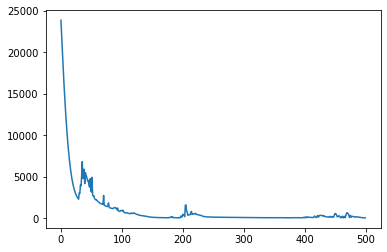

In [ ]:
mv_net2.train()
loss_list = []
for t in range(train_episodes):
    for b in range(0,len(X),batch_size):
        inpt = X[b:b+batch_size,:,:]
        target = y[b:b+batch_size]    
        
        x_batch = torch.tensor(inpt,dtype=torch.float32)    
        y_batch = torch.tensor(target,dtype=torch.float32)

        # mv_net.init_hidden(x_batch.size(0))
        
        output = mv_net1(x_batch) 
        loss = criterion(output.view(-1), y_batch)  
        
        loss.backward()
        optimizer.step()
        # print(mv_net.hidden)        
        optimizer.zero_grad() 
    loss_list.append(loss.item())
    # print('step : ' , t , 'loss : ' , loss.item())
plt.plot(loss_list)
plt.show()

In [ ]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2,
                                                    random_state=40)

In [ ]:
X_tr, X_va, y_tr, y_va = train_test_split(X_tr, y_tr, test_size=0.2,
                                                    random_state=40)

In [ ]:
X_tr.shape, X_va.shape, X_te.shape, y_tr.shape, y_va.shape,  y_te.shape

(torch.Size([4, 3, 2]),
 torch.Size([2, 3, 2]),
 torch.Size([2, 3, 2]),
 torch.Size([4]),
 torch.Size([2]),
 torch.Size([2]))

In [ ]:
train_loader = DataLoader(LSTMDataset(X_tr, y_tr), batch_size = batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(LSTMDataset(X_va, y_va), batch_size = batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(LSTMDataset(X_te, y_te), batch_size = batch_size, shuffle=True, drop_last=True)

In [ ]:
for i,j in train_loader:
  print(j)
  break

tensor([145, 105])


In [ ]:
for i,j in train_dataloader:
  print(j)
  break

tensor([ 26.6000,  50.6000,  19.3000,  22.6200,  57.0000,   5.6200, 158.0400,
          1.6500,  57.8700,  35.4800,  47.8600,  50.3600, 114.2800,  15.1200,
         46.7100,  76.3300], dtype=torch.float64)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


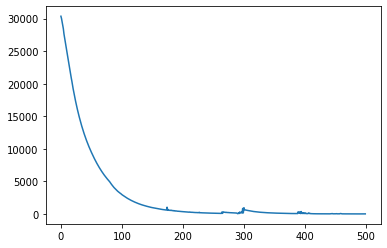

In [ ]:
mv_net2 = LSTMV2(20, n_features,n_timesteps, 1).double()
n_features = 2 # this is number of parallel inputs
n_timesteps = 3 # this is number of timesteps

# create NN

criterion = torch.nn.MSELoss() # reduction='sum' created huge loss value
optimizer = torch.optim.Adam(mv_net2.parameters(), lr=1e-2)


train_episodes = 500
batch_size = 2
mv_net2.train()
loss_list = []
for t in range(train_episodes):
    for b in range(0,len(X),batch_size):
        inpt = X[b:b+batch_size,:,:]
        target = y[b:b+batch_size]    
        
        x_batch = torch.tensor(inpt,dtype=torch.double)    
        y_batch = torch.tensor(target,dtype=torch.double)

        h = mv_net2.init_hidden(x_batch.size(0))
        
        output, h = mv_net2(x_batch, h) 
        loss = criterion(output.view(-1), y_batch)  
        
        loss.backward()
        optimizer.step()
        # print(mv_net.hidden)        
        optimizer.zero_grad() 
    loss_list.append(loss.item())
    # print('step : ' , t , 'loss : ' , loss.item())
plt.plot(loss_list)
plt.show()

In [ ]:
counter = 0
mv_net2 = LSTMV2(20, n_features,n_timesteps, 1).double()
criterion = torch.nn.MSELoss() # reduction='sum' created huge loss value
optimizer = torch.optim.Adam(mv_net2.parameters(), lr=1e-2)
mv_net2.train()
for i in range(500):
  h = mv_net2.init_hidden(batch_size)

  for inputs, labels in train_loader:
    counter += 1
    mv_net2.zero_grad()
    output, _ = mv_net2(inputs, h)
    loss = criterion(output.squeeze(), labels)
    loss.backward()
    # torch.nn.utils.clip_grad_norm_(mv_net2.parameters(),clip)
    optimizer.step()

    if counter % 10 == 0:
      val_h = mv_net2.init_hidden(batch_size)
      val_losses = []
      mv_net2.eval()
      with torch.no_grad():
        for inputs, labels in val_loader:
          out, val_h = mv_net2(inputs, val_h)
          val_loss = criterion(out.squeeze(), labels)
          val_losses.append(val_loss)
        
      mv_net2.train()
      print("Epoch: {}/{}...".format(i+1, epochs),
      "Step: {}...".format(counter),
      "Loss: {:.6f}...".format(loss.item()),
      "Val Loss: {:.6f}".format(np.mean(val_losses)))
    
      # if np.mean(val_losses) <= valid_loss_min:
      #     torch.save(lstmv2.state_dict(), '/content/drive/Shareddrives/CFA project/checkpoints/state_dict.pt')
      #     print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
      #     valid_loss_min = np.mean(val_losses)

Epoch: 5/1000... Step: 10... Loss: 8831.157681... Val Loss: 20901.749399
Epoch: 10/1000... Step: 20... Loss: 13076.991195... Val Loss: 19997.296421
Epoch: 15/1000... Step: 30... Loss: 9862.178373... Val Loss: 18650.423430
Epoch: 20/1000... Step: 40... Loss: 12369.456225... Val Loss: 16978.520617
Epoch: 25/1000... Step: 50... Loss: 5446.415473... Val Loss: 15418.783902
Epoch: 30/1000... Step: 60... Loss: 3157.849273... Val Loss: 13974.101557
Epoch: 35/1000... Step: 70... Loss: 3875.578771... Val Loss: 12698.964572
Epoch: 40/1000... Step: 80... Loss: 1102.563880... Val Loss: 11559.175682
Epoch: 45/1000... Step: 90... Loss: 1886.140358... Val Loss: 10566.019876
Epoch: 50/1000... Step: 100... Loss: 676.070859... Val Loss: 9678.860238
Epoch: 55/1000... Step: 110... Loss: 4299.044033... Val Loss: 8904.786750
Epoch: 60/1000... Step: 120... Loss: 1218.127072... Val Loss: 8204.669037
Epoch: 65/1000... Step: 130... Loss: 3683.122749... Val Loss: 7585.468967
Epoch: 70/1000... Step: 140... Loss: 9

In [ ]:
sorted([4,1,3,5,2], reverse=True)

[5, 4, 3, 2, 1]